In [1]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd

Used https://github.com/binga/fastai_notes/tree/master/experiments/notebooks/lang_models
and https://github.com/sgugger/Deep-Learning/blob/master/Building%20a%20French%20LM.ipynb
as starting points

# Data Preparation

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = Path('..')/'data/translate/wikimedia/russian/'

In [3]:
LM_PATH=Path('..')/'data/translate/lm/russian/russian_lm/'
LM_PATH.mkdir(exist_ok=True)

In [4]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

141


['../data/translate/wikimedia/russian/AA/wiki_08',
 '../data/translate/wikimedia/russian/AA/wiki_65',
 '../data/translate/wikimedia/russian/AA/wiki_52',
 '../data/translate/wikimedia/russian/AA/wiki_69',
 '../data/translate/wikimedia/russian/AA/wiki_40']

In [5]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [6]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Russian_Corpus.csv", index=False)

In [7]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Russian_Corpus.csv")

In [8]:
(LANG_TEXT.assign(labels = 0)
    .pipe(lambda x: x[['labels', 'text']])
    .to_csv(f"{LM_PATH}/Wiki_Russian_Corpus2.csv", header=None, index=False))

# Wikipedian Russian statistics

In [9]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

### Number of documents

In [10]:
LANG_TEXT.shape

(734569, 4)

### Number of words in all the documents

In [11]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

3063350

### Number of unique tokens across documents

In [12]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

145006

In [19]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [20]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Russian_Corpus2.csv", header=None)#, chunksize=5000)

In [21]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [22]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [23]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [24]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
0
1
2
3
4
5
6
7


In [25]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [26]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [27]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[('\n', 1927420),
 ('=', 1221157),
 ('\n\n', 730586),
 ('1', 661340),
 ('xbos', 661112),
 ('xfld', 661112),
 ('от', 623936),
 ('этимология.', 620296),
 ('\n\n\n\n\n\n\n', 565591),
 ('происходит', 437844),
 (',', 56305),
 ('и', 40833),
 ('.', 32786),
 ('\n\n\n', 27309),
 ('библиография.', 25366),
 ('сочетания.', 22649),
 ('свойства.', 22624),
 ('устойчивые', 22316),
 ('фразеологизмы', 22313),
 ('далее', 20375),
 ('из', 19046),
 (')', 19001),
 ('\n\n\n\n\n\n', 18758),
 ('(', 18448),
 ('\n\n\n\n', 13646)]

In [42]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [43]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

7836

In [44]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [45]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [46]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [47]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(7836, 661112)

# Model Setup

In [48]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/
# mv models/ {LM_PATH}

In [49]:
#embedding size, humber of hidden and layers all from wt103 trained by JH
em_sz = 400
nh = 1150
nl = 3

#PRE_PATH = LM_PATH/'models'/'wt103'
#PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

# itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb')) # mapping the itos from wiki to our own mapping
# stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [50]:
# we train from scratch so these are unused
# wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

# enc_wgts = to_np(wgts['0.encoder.weight'])
# row_m = enc_wgts.mean(0)

# wgts['0.encoder.weight'] = T(new_w)
# wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
# wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language Model

In [51]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [52]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [53]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 # if you're overfitting, increase this. Underfitting? decrease this.

In [54]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()

In [55]:
lr=1e-3
lrs = lr

In [56]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # last layer is the embedding weights

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.445774   0.420129   0.906554  



[array([0.42013]), 0.9065544275316852]

In [57]:
learner.save('lm_russian_v2')

In [58]:
learner.load('lm_russian_v2')

In [59]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.467792   0.434419   0.903387  



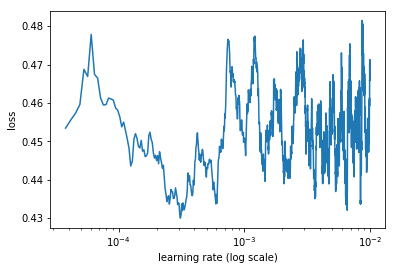

In [60]:
learner.sched.plot()

In [61]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.417195   0.393984   0.910104  



[array([0.39398]), 0.9101043604481297]

In [62]:
learner.save('lm_russian_v2_2')

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.418811   0.392492   0.910056  
    1      0.407398   0.386538   0.910732  
    2      0.401368   0.381155   0.911523  
    3      0.389293   0.378633   0.911831  
    4      0.385673   0.375971   0.912274  
    5      0.380319   0.374826   0.912493  
    6      0.378932   0.374146   0.912541  
    7      0.37267    0.3725     0.912862  
    8      0.374339   0.372476   0.912993  
    9      0.366713   0.371565   0.913083  
    10     0.3621     0.371797   0.913147  
    11     0.361841   0.370993   0.913322  
    12     0.358128   0.371332   0.913356  


In [ ]:
learner.save('lm_russian_v2_3')

In [ ]:
learner.save_encoder('lm_russian_v2_3_enc')

In [ ]:
### Try with lower learning rate

TODO use new training API to optimize this

In [ ]:
learner.load('lm_russian_v2_3')

In [ ]:
lr = 1e-4
lrs = lr
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

In [ ]:
learner.save('lm_russian_v2_4')

In [ ]:
learner.save_encoder('lm_russian_v2_4_enc')

### Generate text

In [ ]:
learner.load("lm_russian3")

In [ ]:
m = learner.model
m.eval()
m[0].bs = 1

## Inference

In [ ]:
sen = """Привет как дела"""

In [ ]:
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

In [ ]:
VV(idxs)

In [ ]:
probs = learner.model(VV(idxs))

In [ ]:
type(probs), len(probs)

In [ ]:
learner.model

In [ ]:
probs[0].shape, [x.shape for x in probs[1]], [x.shape for x in probs[2]]

In [ ]:
# probs[0] is most likely the output vector

### Arvind's answer

In [ ]:
def get_next(inp):
#     m[0].bs = 1 ## why?
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #pdb.set_trace()
    i = np.argmax(to_np(p)[0], 1)[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #i = np.argmax(to_np(p)[0], 1)[0]
    i = torch.topk(p[0][-1], 1)[1].data[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    m[0].bs =1
    #print(inp)
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    probs = m(VV(idxs))
    encc = probs[-1][-1][-1][-1].squeeze()
    pred = to_np(learner.model[1].decoder(encc).exp()).argmax()
    try:
        r = itos[pred]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        # res += c # ???
        res = res + " " + c
        #print(res)
        inp = inp.strip().split(" ") + [c]        
#         inp = ' '.join(inp[1:])
        inp = ' '.join(inp)
        
    return res

In [ ]:
m = learner.model
m.eval()
m[0].bs = 1

In [ ]:
sen = """это тяжелая работа"""
get_next_n(sen, 10)

In [ ]:
sen = """машины могут быть полезны для"""
get_next_n(sen, 10)


In [ ]:
sen = """сколько людей это занимает"""
get_next_n(sen, 10)

# Classifier Tokens

In [56]:
CLAS_PATH = Path("lm/russian/russian_clas/")
LM_PATH.mkdir(exist_ok=True)

In [57]:
df_clas_data = pd.read_csv(CLAS_PATH/"ACTSA_russian_polarity_annotated_UTF.txt", sep="\t", header=None)
df_clas_data[1] = df_clas_data[0].str[2:]
df_clas_data[0] = df_clas_data[0].str[0:2]

# Cleaning the target
df_clas_data[0] = df_clas_data[0].str.strip()
df_clas_data = df_clas_data[df_clas_data[0] != '+'].reset_index(drop=True)
df_clas_data[0] = df_clas_data[0].astype(np.float32)

df_clas_data.to_csv(CLAS_PATH/"Russian_Sentiment_Data.csv", index=False)

# Ignoring neutral class for this exercise
df_clas_data = df_clas_data[df_clas_data[0] != 0].reset_index(drop=True)

# Creating train and validation sets
np.random.seed(42)
trn_keep = np.random.rand(len(df_clas_data))>0.1
df_trn = df_clas_data[trn_keep]
df_val = df_clas_data[~trn_keep]

# Saving train and validation sets to disk
df_trn.to_csv(CLAS_PATH/"Russian_Sentiment_Data_Train.csv", header=None, index=False)
df_val.to_csv(CLAS_PATH/"Russian_Sentiment_Data_Test.csv", header=None, index=False)

len(df_trn),len(df_val)

(2615, 315)

In [58]:
chunksize = 10000
df_trn = pd.read_csv(CLAS_PATH/"Russian_Sentiment_Data_Train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"Russian_Sentiment_Data_Test.csv", header=None, chunksize=chunksize)

In [59]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [60]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [61]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [62]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [63]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [64]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

# Classifier

In [65]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [66]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [67]:
Counter(trn_labels)

Counter({-1: 1290, 1: 1325})

In [68]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [69]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [70]:
c

3

In [71]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [72]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [73]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [74]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [75]:
m

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.3)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.3)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.3)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=3, bias=True)
        (drop): 

In [ ]:
# learner= md.get_model(opt_fn, em_sz, nh, nl, 
#     dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

# learner.metrics = [accuracy]
# learner.unfreeze()

In [76]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [77]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [78]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [79]:
wd = 1e-7
wd = 0
learn.load_encoder('lm_russian_v2_3_enc')

In [80]:
learn.freeze_to(-1)

In [81]:
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 90/109 [00:01<00:00, 64.73it/s, loss=4.43] 


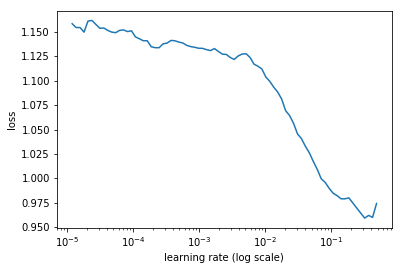

In [82]:
learn.sched.plot()

In [83]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8, 3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.805629   0.690575   0.638916  



[array([0.69057]), 0.6389158056225888]

In [84]:
learn.save('clas_0')

In [85]:
learn.load('clas_0')

In [86]:
learn.freeze_to(-2)

In [87]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8, 3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.666295   0.616798   0.644689  



[array([0.6168]), 0.6446893987960594]

In [88]:
learn.unfreeze()

In [89]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32, 10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.642292   0.613381   0.648956  
    1      0.637285   0.596132   0.654797                    
    2      0.622529   0.577279   0.648323                    
    3      0.592932   0.564014   0.689317                    
    4      0.595894   0.547979   0.648646                    
    5      0.568898   0.5325     0.712384                    
    6      0.564322   0.523673   0.719867                    
    7      0.541882   0.50829    0.70766                     
    8      0.525401   0.503269   0.72307                     
    9      0.532941   0.499391   0.706866                    
    10     0.535057   0.502889   0.719611                    
    11     0.511008   0.499853   0.727404                    
    12     0.500359   0.498179   0.731522                    
    13     0.48697    0.500104   0.724981                    



[array([0.5001]), 0.7249811589717865]

In [90]:
learn.save('clas_1')